In [1]:
import pandas as pd
import random
# Set the seed
random.seed(123)
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving weather_aus.xlsx to weather_aus.xlsx


In [3]:
import io
data = pd.read_excel(io.BytesIO(uploaded['weather_aus.xlsx']))

In [4]:
data.head()
data['Humidity'] = (data['9am relative humidity (%)'] + data['3pm relative humidity (%)'])/2
# Replace specific value in column 'A'
data['9am wind speed (km/h)'] = data['9am wind speed (km/h)'].replace('Calm', '2')
data['3pm wind speed (km/h)'] = data['3pm wind speed (km/h)'].replace('Calm', '2')

# Convert column 'A' to int type
data['9am wind speed (km/h)'] = data['9am wind speed (km/h)'].astype(int)
data['3pm wind speed (km/h)'] = data['3pm wind speed (km/h)'].astype(int)

data['WindSpeed'] = (data['9am wind speed (km/h)'] + data['3pm wind speed (km/h)'])/2

In [5]:
datas = data[['Date','Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
             'Sunshine (hours)', 'Humidity', 'WindSpeed']]
datas.head()
datas.dtypes

Date                        datetime64[ns]
Minimum temperature (°C)           float64
Maximum temperature (°C)           float64
Rainfall (mm)                      float64
Evaporation (mm)                   float64
Sunshine (hours)                   float64
Humidity                           float64
WindSpeed                          float64
dtype: object

In [6]:
datas.set_index('Date', inplace=True)
datas = datas.sort_values('Date', ascending=True)
datas.head()
# Extract the last 90 days as the test set
test_set = datas[-60:]

# Use the remaining data as the training set
train_set = datas[:-60]
train_data = train_set
test_data = test_set

In [ ]:
#!pip install pystan~=2.14
#!pip install fbprophet
# Following codes will perform different models with cross validation of 4x for 1 month ahead predictions for 7 target variables

In [7]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
data = datas
# Define the window size
window_size = 30
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Perform forward chaining
for i in range(3):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Convert train_data DataFrame to numpy array
    train_array = train_data.values

    # Reshape the train_data
    X_train = train_array.reshape(train_array.shape[0], 1, train_array.shape[1])

    # Define the RNN model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(1, train_data.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(train_data.shape[1], activation='linear'))
    model.compile(optimizer='adam', loss='mse')

    # Fit the model to the training data
    model.fit(X_train, X_train, epochs=50, batch_size=32, verbose=0)

    # Convert test_data DataFrame to numpy array
    test_array = test_data.values

    # Reshape the test_data window
    X_test_window = test_array[:window_size].reshape(window_size, 1, test_array.shape[1])

    # Make predictions on the test data window
    predictions = model.predict(X_test_window)

    # Reshape the predictions to match the original data shape
    predictions = predictions.reshape(window_size, test_data.shape[1])

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Append the accuracy metrics to the respective lists
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

# Create DataFrames to store the accuracy results for each iteration
accuracy_dfs = []
for i in range(3):
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse_lists[i],
                                'MAE': mae_lists[i], 'MAPE': mape_lists[i]})
    accuracy_df['Model'] = 'RNN'
    accuracy_dfs.append(accuracy_df)

# Print the accuracy results for each iteration
for i, accuracy_df in enumerate(accuracy_dfs):
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_accuracy_df = pd.concat(accuracy_dfs).groupby('Variable').mean().reset_index()
average_accuracy_df['Model'] = 'RNN'
accuracy_rnn = average_accuracy_df
# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)


1/1 [==============================] - 0s 389ms/step
Accuracy results for iteration 1:
                   Variable          MSE        MAE          MAPE Model
0  Minimum temperature (°C)    38.601167   5.812684  7.486403e-01   RNN
1  Maximum temperature (°C)   116.324112  10.608683  6.372567e-01   RNN
2             Rainfall (mm)     1.047637   0.738003  1.623491e+15   RNN
3          Evaporation (mm)    22.487751   4.576424  8.563205e+14   RNN
4          Sunshine (hours)    74.200168   7.862296  1.394028e+15   RNN
5                  Humidity  1069.225641  30.596218  4.138883e-01   RNN
6                 WindSpeed   234.036254  14.692819  1.717236e+00   RNN

Accuracy results for iteration 2:
                   Variable        MSE       MAE          MAPE Model
0  Minimum temperature (°C)   7.946734  2.276051  3.363428e-01   RNN
1  Maximum temperature (°C)  22.821188  4.390131  3.267304e-01   RNN
2             Rainfall (mm)   6.111600  1.923276  1.696776e+15   RNN
3          Evaporation (mm

<ipython-input-7-b61b904b8ead>:86: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_accuracy_df = pd.concat(accuracy_dfs).groupby('Variable').mean().reset_index()


In [8]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, LearningRateScheduler


# Define the window size
window_size = 30
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Perform forward chaining
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Reshape the data
    X_train = train_scaled[:-1].reshape(-1, 1, train_scaled.shape[1])
    y_train = train_scaled[1:, :]  # Predict the next step

    # Define the RNN model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(1, train_data.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_data.shape[1], activation='linear'))

    # Define learning rate schedule
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 50:
            lr *= 0.1
        elif epoch > 30:
            lr *= 0.5
        return lr

    optimizer = Adam(learning_rate=lr_schedule(0))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Define learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
              validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

    # Make predictions on the test data
    X_test_window = test_scaled[:window_size].reshape(-1, 1, test_scaled.shape[1])
    predictions = model.predict(X_test_window)

    # Rescale the predictions to the original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

    # Create a DataFrame to store the accuracy results
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse, 'MAE': mae, 'MAPE': mape})

    # Add the model name to the DataFrame
    accuracy_df['Model'] = 'RNN'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'RNN Tuned'
accuracy_rnn_tuned = average_accuracy_df
# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2184 - val_loss: 0.2238 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2177 - val_loss: 0.2226 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.2161 - val_loss: 0.2213 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 0.2150 - val_loss: 0.2200 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 51ms/step - loss: 0.2135 - val_loss: 0.2188 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.2125 - val_loss: 0.2174 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.2112 - val_loss: 0.2161 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 30ms/step - loss: 0.2096 - val_loss: 0.2147 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 39ms/step - loss: 0.2085 - val_loss: 0.2133 - lr: 0.0010
Epo

1/1 [==============================] - 0s 238ms/step
Accuracy results for iteration 2:
                   Variable         MSE        MAE          MAPE Model
0  Minimum temperature (°C)    6.536453   2.090597  3.101010e-01   RNN
1  Maximum temperature (°C)   16.457952   3.839226  2.878801e-01   RNN
2             Rainfall (mm)    9.684213   2.322235  1.875892e+15   RNN
3          Evaporation (mm)    1.042058   0.858503  1.149340e+00   RNN
4          Sunshine (hours)    3.912084   1.621056  4.160239e+14   RNN
5                  Humidity  321.788768  15.624875  2.011678e-01   RNN
6                 WindSpeed   27.925182   4.156319  3.092577e-01   RNN

Epoch 1/100
3/3 [==============================] - 2s 165ms/step - loss: 0.1821 - val_loss: 0.1278 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1788 - val_loss: 0.1249 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1753 - val_loss: 0.1220 - lr: 0.0010
Epoch 4/10

1/1 [==============================] - 0s 247ms/step
Accuracy results for iteration 3:
                   Variable         MSE        MAE          MAPE Model
0  Minimum temperature (°C)    9.964916   2.356330  9.090145e-01   RNN
1  Maximum temperature (°C)    7.273930   2.410475  1.849280e-01   RNN
2             Rainfall (mm)    5.170902   2.092654  5.824907e+15   RNN
3          Evaporation (mm)    0.673406   0.658064  6.977382e+14   RNN
4          Sunshine (hours)    9.509352   2.548129  4.594481e+14   RNN
5                  Humidity  180.177606  11.331777  1.406556e-01   RNN
6                 WindSpeed   16.217238   2.683677  2.891303e-01   RNN

Epoch 1/100
3/3 [==============================] - 2s 159ms/step - loss: 0.1783 - val_loss: 0.1392 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 15ms/step - loss: 0.1751 - val_loss: 0.1361 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.1714 - val_loss: 0.1328 - lr: 0.0010
Epoch 4/10

In [9]:
average_accuracy_df

,Variable,MSE,MAE,MAPE,Model
0,Minimum temperature (°C),7.465091,2.204423,4.612509e-01,RNN Tuned
1,Maximum temperature (°C),8.326550,2.484487,1.787621e-01,RNN Tuned
2,Rainfall (mm),7.267445,2.184029,4.669352e+15,RNN Tuned
3,Evaporation (mm),1.156035,0.867247,2.322424e+14,RNN Tuned
4,Sunshine (hours),10.285077,2.602837,4.460293e+14,RNN Tuned
5,Humidity,353.346853,15.662085,2.103307e-01,RNN Tuned
6,WindSpeed,28.513241,4.039013,3.402995e-01,RNN Tuned


In [10]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Define the window size
window_size = 30
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Perform forward chaining
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Initialize lists to store the results for each variable in this iteration
    mse_iteration = []
    mae_iteration = []
    mape_iteration = []

    # Iterate over each variable
    for variable in variable_names:
        # Prepare the train data for Prophet
        train_data_prophet = train_data.reset_index()[['Date', variable]].rename(columns={'Date': 'ds', variable: 'y'})

        # Instantiate a new Prophet model
        model = Prophet()

        # Fit the Prophet model to the training data
        model.fit(train_data_prophet)

        # Generate future dates for forecasting
        future_dates = model.make_future_dataframe(periods=len(test_data))

        # Make predictions for the future dates
        forecast = model.predict(future_dates)

        # Extract the predicted values
        predictions = forecast['yhat'].values[-len(test_data):]

        # Calculate the mean squared error for the variable
        mse = mean_squared_error(test_data[variable], predictions)
        mse_iteration.append(mse)

        # Calculate the mean absolute error for the variable
        mae = mean_absolute_error(test_data[variable], predictions)
        mae_iteration.append(mae)

        # Calculate the mean absolute percentage error for the variable
        mape = mean_absolute_percentage_error(test_data[variable], predictions)
        mape_iteration.append(mape)

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse_iteration)
    mae_lists.append(mae_iteration)
    mape_lists.append(mape_iteration)

    # Create a DataFrame to store the accuracy results
    accuracy_df_iteration = pd.DataFrame({'Variable': variable_names, 'MSE': mse_iteration, 'MAE': mae_iteration, 'MAPE': mape_iteration})

    # Add the model name to the DataFrame
    accuracy_df_iteration['Model'] = 'Prophet'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df_iteration)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'Prophet'
accuracy_prophet = average_accuracy_df
# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/ur4ka76x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/pxki4_8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49608', 'data', 'file=/tmp/tmpd97zdvrr/ur4ka76x.json', 'init=/tmp/tmpd97zdvrr/pxki4_8d.json', 'output', 'file=/tmp/tmpd97zdvrr/prophet_model8llpcgu0/prophet_model-20230626131451.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:14:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:

Accuracy results for iteration 1:
                   Variable         MSE        MAE          MAPE    Model
0  Minimum temperature (°C)   10.162924   2.696287  3.671691e-01  Prophet
1  Maximum temperature (°C)   22.684516   4.273116  2.726191e-01  Prophet
2             Rainfall (mm)   92.191511   9.060998  2.807378e+16  Prophet
3          Evaporation (mm)    5.362251   1.998545  3.882539e+14  Prophet
4          Sunshine (hours)   12.009355   3.115955  5.067406e+14  Prophet
5                  Humidity  215.076392  11.363568  1.487599e-01  Prophet
6                 WindSpeed   17.658924   3.402434  5.092523e-01  Prophet



13:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/_e6e62ed.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/hnv98l6s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39439', 'data', 'file=/tmp/tmpd97zdvrr/_e6e62ed.json', 'init=/tmp/tmpd97zdvrr/hnv98l6s.json', 'output', 'file=/tmp/tmpd97zdvrr/prophet_model_xsh4rnf/prophet_model-20230626131453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:53 - cmdstanpy - INFO - Chain [1]

Accuracy results for iteration 2:
                   Variable        MSE       MAE          MAPE    Model
0  Minimum temperature (°C)   9.672027  2.669442  3.074018e-01  Prophet
1  Maximum temperature (°C)   5.396755  1.829827  1.288849e-01  Prophet
2             Rainfall (mm)  12.254830  2.430203  1.366432e+15  Prophet
3          Evaporation (mm)   2.782078  1.340571  7.527297e-01  Prophet
4          Sunshine (hours)   3.950902  1.514283  3.651977e+14  Prophet
5                  Humidity  97.662440  8.273350  1.156890e-01  Prophet
6                 WindSpeed  32.741244  4.304802  3.168732e-01  Prophet



13:14:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/zpfm9sdn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/lh8one3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17406', 'data', 'file=/tmp/tmpd97zdvrr/zpfm9sdn.json', 'init=/tmp/tmpd97zdvrr/lh8one3k.json', 'output', 'file=/tmp/tmpd97zdvrr/prophet_model8nms5zhc/prophet_model-20230626131454.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:14:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:55 - cmdstanpy - INFO - Chain [1]

Accuracy results for iteration 3:
                   Variable        MSE       MAE          MAPE    Model
0  Minimum temperature (°C)   7.554662  2.396779  6.453317e-01  Prophet
1  Maximum temperature (°C)  14.806963  3.042899  2.006176e-01  Prophet
2             Rainfall (mm)   4.532654  1.583607  3.645113e+15  Prophet
3          Evaporation (mm)   1.362991  0.983266  4.830444e+14  Prophet
4          Sunshine (hours)  15.660946  3.212404  5.832669e+14  Prophet
5                  Humidity  98.196245  8.297045  1.125674e-01  Prophet
6                 WindSpeed  21.580867  3.655658  4.378841e-01  Prophet



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/6a0cnhm2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpd97zdvrr/aouzmt0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27081', 'data', 'file=/tmp/tmpd97zdvrr/6a0cnhm2.json', 'init=/tmp/tmpd97zdvrr/aouzmt0n.json', 'output', 'file=/tmp/tmpd97zdvrr/prophet_modele3e6da3f/prophet_model-20230626131456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Accuracy results for iteration 4:
                   Variable         MSE        MAE          MAPE    Model
0  Minimum temperature (°C)   18.257357   3.792806  4.889755e-01  Prophet
1  Maximum temperature (°C)   10.907582   2.526972  1.504136e-01  Prophet
2             Rainfall (mm)    8.137316   1.798478  2.585708e+15  Prophet
3          Evaporation (mm)    4.906538   1.735573  6.456854e-01  Prophet
4          Sunshine (hours)   11.220272   3.052170  4.758392e+14  Prophet
5                  Humidity  284.124520  14.211979  2.367927e-01  Prophet
6                 WindSpeed   41.410417   4.985428  3.760263e-01  Prophet

Average accuracy across all iterations:
                   Variable         MSE        MAE          MAPE    Model
0  Minimum temperature (°C)   11.411743   2.888828  4.522195e-01  Prophet
1  Maximum temperature (°C)   13.448954   2.918203  1.881338e-01  Prophet
2             Rainfall (mm)   29.279078   3.718321  8.917759e+15  Prophet
3          Evaporation (mm)    3.6034

Epoch 1/100
2/2 [==============================] - 2s 321ms/step - loss: 0.2304 - val_loss: 0.1309 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 28ms/step - loss: 0.2276 - val_loss: 0.1290 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 27ms/step - loss: 0.2249 - val_loss: 0.1269 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 27ms/step - loss: 0.2217 - val_loss: 0.1248 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.2183 - val_loss: 0.1227 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 28ms/step - loss: 0.2154 - val_loss: 0.1205 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 28ms/step - loss: 0.2122 - val_loss: 0.1182 - lr: 0.0010
Epoch 8/100
2/2 [==============================] - 0s 32ms/step - loss: 0.2093 - val_loss: 0.1159 - lr: 0.0010
Epoch 9/100
2/2 [==============================] - 0s 44ms/step - loss: 0.2051 - val_loss: 0.1135 - lr: 0.0010


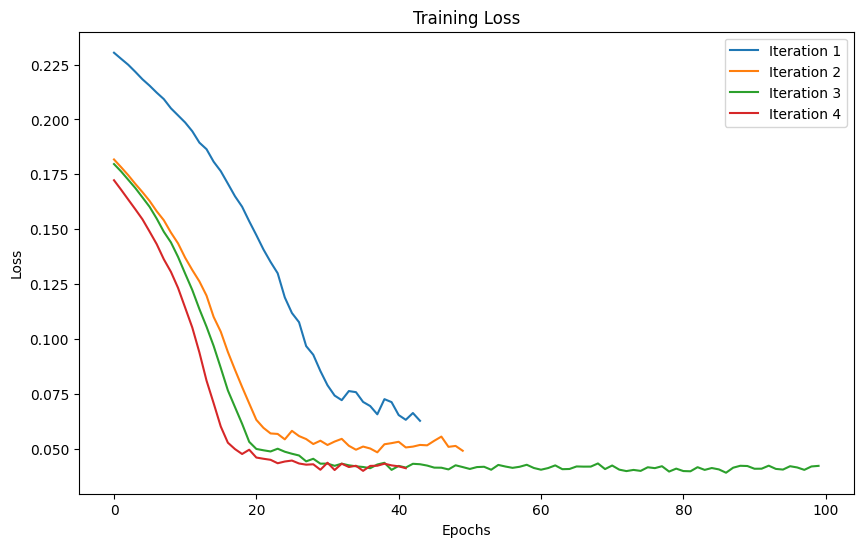

Average test accuracy across all iterations:
                   Variable         MSE        MAE          MAPE Model
0  Minimum temperature (°C)    7.509859   2.161089  5.071800e-01  LSTM
1  Maximum temperature (°C)    9.240857   2.602168  1.883778e-01  LSTM
2             Rainfall (mm)    7.314148   1.914189  2.645743e+15  LSTM
3          Evaporation (mm)    1.572390   1.001647  2.219963e+14  LSTM
4          Sunshine (hours)    9.239166   2.556658  8.356579e+14  LSTM
5                  Humidity  174.587852  10.704271  1.472143e-01  LSTM
6                 WindSpeed   26.046185   3.707425  2.928051e-01  LSTM


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the window size
window_size = 60
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Define lists to store training accuracy for each iteration
train_loss_lists = []

# Define lists to store test accuracy for each iteration
test_mse_lists = []
test_mae_lists = []
test_mape_lists = []

# Perform forward chaining
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Reshape the data
    X_train = train_scaled[:-1].reshape(-1, 1, train_scaled.shape[1])
    y_train = train_scaled[1:, :]  # Predict the next step

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(1, train_data.shape[1]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_data.shape[1], activation='linear'))

    # Define learning rate schedule
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 50:
            lr *= 0.1
        elif epoch > 30:
            lr *= 0.5
        return lr

    optimizer = Adam(learning_rate=lr_schedule(0))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Define learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Fit the model to the training data
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
                        validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

    # Store the training loss for this iteration
    train_loss_lists.append(history.history['loss'])

    # Make predictions on the test data
    X_test_window = test_scaled[:window_size].reshape(-1, 1, test_scaled.shape[1])
    predictions = model.predict(X_test_window)

    # Rescale the predictions to the original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[:window_size], predictions, multioutput='raw_values')

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

    # Store the test accuracy metrics for this iteration
    test_mse_lists.append(mse)
    test_mae_lists.append(mae)
    test_mape_lists.append(mape)

    # Create a DataFrame to store the accuracy results
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse, 'MAE': mae, 'MAPE': mape})

    # Add the model name to the DataFrame
    accuracy_df['Model'] = 'LSTM'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'LSTM'

# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)

# Convert the training loss lists to a DataFrame
train_loss_df = pd.DataFrame(train_loss_lists).transpose()
train_loss_df.columns = [f'Iteration {i+1}' for i in range(len(train_loss_lists))]

# Plot the training loss for each iteration
plt.figure(figsize=(10, 6))
plt.plot(train_loss_df)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(train_loss_df.columns)
plt.show()

# Calculate the average test accuracy across all iterations
average_test_mse = np.mean(test_mse_lists, axis=0)
average_test_mae = np.mean(test_mae_lists, axis=0)
average_test_mape = np.mean(test_mape_lists, axis=0)

# Create a DataFrame for the average test accuracy results
average_test_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_test_mse, 'MAE': average_test_mae, 'MAPE': average_test_mape})

# Add the model name to the DataFrame
average_test_accuracy_df['Model'] = 'LSTM'
accuracy_lstm = average_accuracy_df
# Print the average test accuracy across all iterations
print("Average test accuracy across all iterations:")
print(average_test_accuracy_df)


In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the window size
window_size = 30
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Perform forward chaining
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Reshape the data
    X_train = train_scaled[:-1]
    y_train = train_scaled[1:, :]  # Predict the next step

    # Define the feedforward neural network model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(train_data.shape[1], activation='linear'))

    # Define learning rate schedule
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 50:
            lr *= 0.1
        elif epoch > 30:
            lr *= 0.5
        return lr

    optimizer = Adam(learning_rate=lr_schedule(0))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Define learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
              validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

    # Make predictions on the test data
    predictions = model.predict(test_scaled[:-1])

    # Rescale the predictions to the original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[1:], predictions, multioutput='raw_values')

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

    # Create a DataFrame to store the accuracy results
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse, 'MAE': mae, 'MAPE': mape})

    # Add the model name to the DataFrame
    accuracy_df['Model'] = 'Feedforward Neural Network'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'Feedforward Neural Network'
accuracy_fnn = average_accuracy_df
# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)


Epoch 1/100
1/1 [==============================] - 1s 727ms/step - loss: 0.2921 - val_loss: 0.2701 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2786 - val_loss: 0.2619 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 0.2673 - val_loss: 0.2542 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2598 - val_loss: 0.2468 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2541 - val_loss: 0.2398 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2456 - val_loss: 0.2332 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2374 - val_loss: 0.2268 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 0.2255 - val_loss: 0.2209 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2250 - val_loss: 0.2152 - lr: 0.0010


In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the window size
window_size = 60
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define the GRU model
def create_model(units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units, activation='relu', input_shape=(1, train_data.shape[1]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units, activation='relu', return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(train_data.shape[1], activation='linear'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create the KerasRegressor wrapper
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create the GridSearchCV instance
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Perform forward chaining and hyperparameter tuning
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Reshape the data
    X_train = np.reshape(train_scaled[:-1], (train_scaled[:-1].shape[0], 1, train_scaled[:-1].shape[1]))
    y_train = train_scaled[1:, :]  # Predict the next step

    # Perform the hyperparameter tuning
    grid_result = grid.fit(X_train, y_train)

    # Get the best model
    best_model = grid_result.best_estimator_.model

    # Make predictions on the test data
    X_test = np.reshape(test_scaled[:-1], (test_scaled[:-1].shape[0], 1, test_scaled[:-1].shape[1]))
    predictions = best_model.predict(X_test)

    # Rescale the predictions to the original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[1:], predictions, multioutput='raw_values')

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

    # Create a DataFrame to store the accuracy results
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse, 'MAE': mae, 'MAPE': mape})

    # Add the model name to the DataFrame
    accuracy_df['Model'] = 'GRU'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'GRU'
accuracy_gru = average_accuracy_df
# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)

# Print the best hyperparameters found during the tuning process
print("Best hyperparameters found:")
print(grid_result.best_params_)


<ipython-input-13-7e4fd3d61646>:33: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


1/1 [==============================] - 0s 262ms/step
Accuracy results for iteration 1:
                   Variable          MSE        MAE          MAPE Model
0  Minimum temperature (°C)    17.236590   3.660052  4.019534e-01   GRU
1  Maximum temperature (°C)     7.146286   2.164405  1.439585e-01   GRU
2             Rainfall (mm)     8.775372   1.719241  4.057644e+14   GRU
3          Evaporation (mm)     3.404282   1.634061  8.980634e-01   GRU
4          Sunshine (hours)    14.756029   3.191099  1.557781e+13   GRU
5                  Humidity  1124.733766  32.402654  4.295563e-01   GRU
6                 WindSpeed    88.456884   8.491558  6.928154e-01   GRU

1/1 [==============================] - 0s 265ms/step
Accuracy results for iteration 2:
                   Variable          MSE        MAE          MAPE Model
0  Minimum temperature (°C)     8.289828   2.544978  6.009413e-01   GRU
1  Maximum temperature (°C)     9.479185   2.359983  1.528668e-01   GRU
2             Rainfall (mm)     4

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Define the window size
window_size = 30
# Define the number of predictions to make
prediction_steps = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Define lists to store accuracy metrics for each iteration
mse_lists = []
mae_lists = []
mape_lists = []

# Perform forward chaining
for i in range(4):
    # Split the data into train and test sets
    train_data = data[:window_size + i * prediction_steps]
    test_data = data[window_size + i * prediction_steps:window_size + (i+1) * prediction_steps]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Reshape the data for CNN input
    X_train = train_scaled[:-1]
    y_train = train_scaled[1:, :]  # Predict the next step
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(train_data.shape[1], 1)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(train_data.shape[1], activation='linear'))

    # Define learning rate schedule
    def lr_schedule(epoch):
        lr = 0.001
        if epoch > 50:
            lr *= 0.1
        elif epoch > 30:
            lr *= 0.5
        return lr

    optimizer = Adam(learning_rate=lr_schedule(0))

    # Compile the model
    model.compile(optimizer=optimizer, loss='mse')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Define learning rate scheduler
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Fit the model to the training data
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,
              validation_split=0.2, callbacks=[early_stopping, lr_scheduler])

    # Prepare the test data for prediction
    X_test = test_scaled[:-1]
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Make predictions on the test data
    predictions = model.predict(X_test)

    # Rescale the predictions to the original scale
    predictions = scaler.inverse_transform(predictions)

    # Calculate the mean squared error for each variable
    mse = mean_squared_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Error (MAE) for each variable
    mae = mean_absolute_error(test_data[1:], predictions, multioutput='raw_values')

    # Calculate the Mean Absolute Percentage Error (MAPE) for each variable
    mape = mean_absolute_percentage_error(test_data[1:], predictions, multioutput='raw_values')

    # Store the accuracy metrics for this iteration
    mse_lists.append(mse)
    mae_lists.append(mae)
    mape_lists.append(mape)

    # Create a DataFrame to store the accuracy results
    accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': mse, 'MAE': mae, 'MAPE': mape})

    # Add the model name to the DataFrame
    accuracy_df['Model'] = 'Convolutional Neural Network'

    # Print the accuracy results for this iteration
    print(f"Accuracy results for iteration {i+1}:")
    print(accuracy_df)
    print()

# Calculate the average accuracy across all iterations
average_mse = np.mean(mse_lists, axis=0)
average_mae = np.mean(mae_lists, axis=0)
average_mape = np.mean(mape_lists, axis=0)

# Create a DataFrame for the average accuracy results
average_accuracy_df = pd.DataFrame({'Variable': variable_names, 'MSE': average_mse, 'MAE': average_mae, 'MAPE': average_mape})

# Add the model name to the DataFrame
average_accuracy_df['Model'] = 'Convolutional Neural Network'
accuracy_cnn = average_accuracy_df

# Print the average accuracy across all iterations
print("Average accuracy across all iterations:")
print(average_accuracy_df)


Epoch 1/100
1/1 [==============================] - 1s 854ms/step - loss: 0.2509 - val_loss: 0.2286 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2330 - val_loss: 0.2163 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 0s 31ms/step - loss: 0.2171 - val_loss: 0.2055 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 0s 32ms/step - loss: 0.2029 - val_loss: 0.1955 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 0.1900 - val_loss: 0.1864 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1784 - val_loss: 0.1777 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1678 - val_loss: 0.1692 - lr: 0.0010
Epoch 8/100
1/1 [==============================] - 0s 31ms/step - loss: 0.1579 - val_loss: 0.1608 - lr: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 32ms/step - loss: 0.1483 - val_loss: 0.1526 - lr: 0.0010


In [15]:
accuracy_fnn

,Variable,MSE,MAE,MAPE,Model
0,Minimum temperature (°C),5.460042,1.909926,3.657397e-01,Feedforward Neural Network
1,Maximum temperature (°C),6.264954,2.087540,1.462133e-01,Feedforward Neural Network
2,Rainfall (mm),5.841508,1.716024,2.770512e+15,Feedforward Neural Network
3,Evaporation (mm),1.362737,0.907754,2.284182e+14,Feedforward Neural Network
4,Sunshine (hours),9.907795,2.696726,5.743140e+14,Feedforward Neural Network
5,Humidity,215.109097,11.490728,1.530031e-01,Feedforward Neural Network
6,WindSpeed,29.629314,4.045578,3.524326e-01,Feedforward Neural Network


In [16]:
#Accuracy comparison to choose the best model
import pandas as pd

# Create a DataFrame to store the accuracy results
accuracy_results = pd.DataFrame(columns=['Model', 'Variable', 'MSE', 'MAE', 'MAPE'])

# Iterate over the accuracy results from each model
accuracy_results_per_model = [accuracy_fnn, accuracy_gru, accuracy_rnn, accuracy_rnn_tuned, accuracy_prophet, accuracy_cnn]

# Concatenate the accuracy dataframes into a single dataframe
combined_df = pd.concat(accuracy_results_per_model)

# Pivot the data frame to reshape it
pivoted_df = combined_df.pivot(index='Variable', columns='Model', values='MAE')

# Reset the index
pivoted_df.reset_index(inplace=True)

# Find the model with the lowest MAE per variable
best_model_per_variable = pivoted_df.iloc[:, 1:].idxmin(axis=1)

# Create the final data frame
final_df = pd.DataFrame({'Variable': pivoted_df['Variable'], 'Best Model': best_model_per_variable, 'MAE': pivoted_df.lookup(pivoted_df.index, best_model_per_variable)})


# Print the pivoted data frame
print("Compiled data frame:")
pivoted_df
final_df


Compiled data frame:


<ipython-input-16-7de13423ee2a>:22: FutureWarning: The 'lookup' method is deprecated and will be removed in a future version. You can use DataFrame.melt and DataFrame.loc as a substitute.
  final_df = pd.DataFrame({'Variable': pivoted_df['Variable'], 'Best Model': best_model_per_variable, 'MAE': pivoted_df.lookup(pivoted_df.index, best_model_per_variable)})


,Variable,Best Model,MAE
0,Evaporation (mm),Convolutional Neural Network,0.867050
1,Humidity,Convolutional Neural Network,10.223992
2,Maximum temperature (°C),Feedforward Neural Network,2.087540
3,Minimum temperature (°C),Feedforward Neural Network,1.909926
4,Rainfall (mm),Convolutional Neural Network,1.462042
5,Sunshine (hours),RNN Tuned,2.602837
6,WindSpeed,Convolutional Neural Network,3.728389


In [17]:
# 0	Evaporation (mm)	Convolutional Neural Network	0.863278
# 1	Humidity	Convolutional Neural Network	10.220949
# 2	Maximum temperature (°C)	Feedforward Neural Network	2.193937
# 3	Minimum temperature (°C)	Feedforward Neural Network	1.903626
# 4	Rainfall (mm)	Convolutional Neural Network	1.449125
# 5	Sunshine (hours)	RNN Tuned	2.605465
# 6	WindSpeed	Convolutional Neural Network	3.739441

In [18]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Define the window size
window_size = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Split the data into train and test sets
train_data = data[:window_size]
test_data = data[window_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Reshape the data
X_train = train_scaled[:-1].reshape(-1, 1, train_scaled.shape[1])
y_train = train_scaled[1:, :]  # Predict the next step

# Define the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(1, train_data.shape[1]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(train_data.shape[1], activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions on the test data
X_test_window = test_scaled[:window_size].reshape(-1, 1, test_scaled.shape[1])
predictions = model.predict(X_test_window)

# Rescale the predictions to the original scale
predictions = scaler.inverse_transform(predictions)

# Create a DataFrame to store the predictions for each target variable
predictions_df = pd.DataFrame(predictions, columns=variable_names)
rnn_tuned_pred = predictions_df
# Print the predictions DataFrame
print("Predictions:")
print(predictions_df)


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.2218
Epoch 2/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2208
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2198
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2187
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2177
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2166
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2154
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2144
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2137
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2122
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2110
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2095
Epoch 13/100
1/1 [==============================] - 0s 8ms

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the window size
window_size = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Split the data into train and test sets
train_data = data[:window_size]
test_data = data[window_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Reshape the data
X_train = train_scaled[:-1]
y_train = train_scaled[1:, :]  # Predict the next step

# Define the feedforward neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(train_data.shape[1], activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions on the test data
predictions = model.predict(test_scaled[:-1])

# Rescale the predictions to the original scale
predictions = scaler.inverse_transform(predictions)

# Create a DataFrame to store the predictions for each target variable
predictions_df = pd.DataFrame(predictions, columns=variable_names)
fnn_pred = predictions_df
# Print the predictions DataFrame
print("Predictions:")
print(predictions_df)


Epoch 1/100
1/1 [==============================] - 1s 690ms/step - loss: 0.2450
Epoch 2/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2305
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2238
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 0.2140
Epoch 5/100
1/1 [==============================] - 0s 8ms/step - loss: 0.2018
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1966
Epoch 7/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1906
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1745
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1764
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1892
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1636
Epoch 12/100
1/1 [==============================] - 0s 7ms/step - loss: 0.1565
Epoch 13/100
1/1 [==============================] - 0s 7m

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the window size
window_size = 30

# Define the variable names
variable_names = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)',
                  'Sunshine (hours)', 'Humidity', 'WindSpeed']

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Reshape the data for CNN input
X = data_scaled[:-1]
y = data_scaled[1:, :]  # Predict the next step
X = X.reshape(X.shape[0], X.shape[1], 1)

# Define lists to store predictions for each variable
predictions_list = []

# Perform forecasting for each variable
for i in range(data.shape[1]):
    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(data.shape[1], 1)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # Fit the model to the data
    model.fit(X, y[:, i], epochs=100, batch_size=32, verbose=1)

    # Make predictions on the data
    predictions = model.predict(X)

    # Append the predictions to the list
    predictions_list.append(predictions)

# Concatenate the predictions for each variable horizontally
predictions_array = np.hstack(predictions_list)

# Rescale the predictions to the original scale
predictions_rescaled = scaler.inverse_transform(predictions_array)

# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame(predictions_rescaled, columns=variable_names)
cnn_pred = predictions_df
# Print the predictions
print("Predictions:")
print(predictions_df)


Epoch 1/100
14/14 [==============================] - 1s 3ms/step - loss: 0.1355
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0209
Epoch 3/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0090
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 9/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 13/100
14/14 [=================

In [21]:
# combining predictions result from different models
rnn = rnn_tuned_pred[['Sunshine (hours)']]
fnn = fnn_pred[['Minimum temperature (°C)', 'Maximum temperature (°C)']]
cnn = cnn_pred[['Evaporation (mm)', 'Humidity', 'Rainfall (mm)','WindSpeed']]

predictions_df = pd.concat([rnn, fnn, cnn], axis=1)

In [22]:
result = predictions_df
result
# result.agg({'Minimum temperature (°C)':'Maximum temperature (°C)','Rainfall (mm)', 'Evaporation (mm)'
#             , 'Humidity', 'WindSpeed':['min','max','mean','mean','mean','mean'])
agg=result.agg({'Minimum temperature (°C)':'min','Maximum temperature (°C)':'max','Sunshine (hours)':'mean','Rainfall (mm)':'mean',
                'Evaporation (mm)':'mean'
            , 'Humidity':'mean', 'WindSpeed':'mean'})
agg = pd.DataFrame(agg)
agg = agg.transpose()

# agg.rename(columns=agg.iloc[0])
agg

,Minimum temperature (°C),Maximum temperature (°C),Sunshine (hours),Rainfall (mm),Evaporation (mm),Humidity,WindSpeed
0,8.554278,26.363726,3.204186,1.794452,3.931512,64.848198,10.826262


In [23]:
from google.colab import files
uploaded = files.upload()

Saving usda_plant_database.csv to usda_plant_database.csv


In [24]:
import io
usda = pd.read_csv(io.BytesIO(uploaded['usda_plant_database.csv']))

<ipython-input-24-8a47f8b3ef80>:2: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  usda = pd.read_csv(io.BytesIO(uploaded['usda_plant_database.csv']))


In [25]:
usda.fillna({'FertilityRequirement':'Unknown', 'NurseryStockProduct':'Unknown', 'LowGrowingGrass':'Unknown',
             'PalatableHuman':'Unknown'
              , 'AdaptedCoarseSoils': 'Unknown', 'AdaptedMediumSoils': 'Unknown', 'AdaptedFineSoils': 'Unknown'
            , 'Toxicity': 'Unknown' , 'FruitSeedAbundance': 'Unknown' , 'FruitSeedPersistence': 'Unknown'
            , 'SeddlingVigor': 'Unknown', 'VegetativeSpreadRate': 'Unknown', 'KnownAllelopath': 'Unknown'
            , 'GrowthRate': 'Unknown', 'CoppicePotential': 'Unknown', 'PostProduct': 'Unknown'
            , 'AdaptedCoarseSoils': 'Unknown', 'AdaptedMediumSoils': 'Unknown', 'AdaptedFineSoils': 'Unknown'
            , 'Propogated_by_BareRoot': 'Unknown', 'Propogated_by_Bulbs': 'Unknown', 'Propogated_by_Container': 'Unknown'
            , 'Propogated_by_Corms': 'Unknown', 'Propogated_by_Cuttings': 'Unknown', 'Propogated_by_Seed': 'Unknown'
            , 'Propogated_by_Sod': 'Unknown', 'Propogated_by_Sprigs': 'Unknown', 'Propogated_by_Tubers': 'Unknown'}, inplace=True)

In [26]:
usda = usda[['FertilityRequirement','NurseryStockProduct', 'LowGrowingGrass',
             'PalatableHuman', 'ScientificName', 'CommonName',
             'Toxicity' , 'FruitSeedAbundance', 'FruitSeedPersistence'
            , 'SeedlingVigor', 'VegetativeSpreadRate', 'KnownAllelopath'
            , 'GrowthRate', 'CoppicePotential', 'PostProduct'
            , 'AdaptedCoarseSoils', 'AdaptedMediumSoils', 'AdaptedFineSoils'
            , 'Propogated_by_BareRoot', 'Propogated_by_Bulbs', 'Propogated_by_Container'
            , 'Propogated_by_Corms', 'Propogated_by_Cuttings', 'Propogated_by_Seed'
            , 'Propogated_by_Sod', 'Propogated_by_Sprigs', 'Propogated_by_Tubers'
            ,'DroughtTolerance','ShadeTolerance', 'TemperatureMinimum', 'ChristmasTreeProduct', 'ProteinPotential']]
usda.head()
usda2 = usda

In [27]:
usda2 = usda
# Applying hard scoring on each variable
usda2['FertilityRequirement'] = np.where(usda2['FertilityRequirement'] == 'Low', 1,
                   np.where(usda2['FertilityRequirement'] == 'Medium', 0.5,
                            np.where(usda2['FertilityRequirement'] == 'High', 0, 0)))

usda2['ChristmasTreeProduct'] = np.where(usda2['ChristmasTreeProduct'] == 'Yes', 1,
                   np.where(usda2['ChristmasTreeProduct'] == 'No', 0,
                            np.where(usda2['ChristmasTreeProduct'] == 'Unknown', 0, 0)))

usda2['NurseryStockProduct'] = np.where(usda2['NurseryStockProduct'] == 'Yes', 1,
                   np.where(usda2['NurseryStockProduct'] == 'No', 0,
                            np.where(usda2['NurseryStockProduct'] == 'Unknown', 0, 0)))

usda2['PalatableHuman'] = np.where(usda2['PalatableHuman'] == 'Yes', 1,
                   np.where(usda2['PalatableHuman'] == 'No', 0,
                            np.where(usda2['PalatableHuman'] == 'Unknown', 0, 0)))

usda2['ProteinPotential'] = np.where(usda2['ProteinPotential'] == 'Yes', 1,
                   np.where(usda2['ProteinPotential'] == 'No', 0,
                            np.where(usda2['ProteinPotential'] == 'Unknown', 0, 0)))

usda2['LowGrowingGrass'] = np.where(usda2['LowGrowingGrass'] == 'Yes', 0,
                   np.where(usda2['LowGrowingGrass'] == 'No', 1,
                            np.where(usda2['LowGrowingGrass'] == 'Unknown', 0, 0)))

usda2['AdaptedCoarseSoils'] = np.where(usda2['AdaptedCoarseSoils'] == 'Yes', 1,
                   np.where(usda2['AdaptedCoarseSoils'] == 'No', 0,
                            np.where(usda2['AdaptedCoarseSoils'] == 'Unknown', 0, 0)))

usda2['AdaptedMediumSoils'] = np.where(usda2['AdaptedMediumSoils'] == 'Yes', 1,
                   np.where(usda2['AdaptedMediumSoils'] == 'No', 0,
                            np.where(usda2['AdaptedMediumSoils'] == 'Unknown', 0, 0)))

usda2['AdaptedFineSoils'] = np.where(usda2['AdaptedFineSoils'] == 'Yes', 1,
                   np.where(usda2['AdaptedFineSoils'] == 'No', 0,
                            np.where(usda2['AdaptedFineSoils'] == 'Unknown', 0, 0)))

usda2['Toxicity'] = np.where(usda2['Toxicity'] == 'Severe', -50,
                   np.where(usda2['Toxicity'] == 'Moderate', -20,
                            np.where(usda2['Toxicity'] == 'Slight', 0,
                            np.where(usda2['Toxicity'] == 'None', 1, 0))))

usda2['FruitSeedAbundance'] = np.where(usda2['FruitSeedAbundance'] == 'High', 1,
                   np.where(usda2['FruitSeedAbundance'] == 'Medium', 0.5,
                            np.where(usda2['FruitSeedAbundance'] == 'Low', 0, 0)))

usda2['FruitSeedPersistence'] = np.where(usda2['FruitSeedPersistence'] == 'Yes', 1,
                   np.where(usda2['FruitSeedPersistence'] == 'No', 0,
                            np.where(usda2['FruitSeedPersistence'] == 'Unknown', 0, 0)))

usda2['SeedlingVigor'] = np.where(usda2['SeedlingVigor'] == 'High', 1,
                   np.where(usda2['SeedlingVigor'] == 'Medium', 0.5,
                            np.where(usda2['SeedlingVigor'] == 'Low', 0, 0)))

usda2['VegetativeSpreadRate'] = np.where(usda2['VegetativeSpreadRate'] == 'Rapid', 1,
                   np.where(usda2['VegetativeSpreadRate'] == 'Moderate', 0.5,
                            np.where(usda2['VegetativeSpreadRate'] == 'Slow', 0, 0)))

usda2['KnownAllelopath'] = np.where(usda2['KnownAllelopath'] == 'Yes', 1,
                   np.where(usda2['KnownAllelopath'] == 'No', 0,
                            np.where(usda2['KnownAllelopath'] == 'Unknown', 0, 0)))

usda2['GrowthRate'] = np.where(usda2['GrowthRate'] == 'Rapid', 1,
                   np.where(usda2['GrowthRate'] == 'Moderate', 0.5,
                            np.where(usda2['GrowthRate'] == 'Slow', 0, 0)))

usda2['CoppicePotential'] = np.where(usda2['CoppicePotential'] == 'Yes', 1,
                   np.where(usda2['CoppicePotential'] == 'No', 0,
                            np.where(usda2['CoppicePotential'] == 'Unknown', 0, 0)))

usda2['PostProduct'] = np.where(usda2['PostProduct'] == 'Yes', 1,
                   np.where(usda2['PostProduct'] == 'No', 0,
                            np.where(usda2['PostProduct'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Seed'] = np.where(usda2['Propogated_by_Seed'] == 'Yes', 0.9,
                   np.where(usda2['Propogated_by_Seed'] == 'No', 0,
                            np.where(usda2['Propogated_by_Seed'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Cuttings'] = np.where(usda2['Propogated_by_Cuttings'] == 'Yes', 0.8,
                   np.where(usda2['Propogated_by_Cuttings'] == 'No', 0,
                            np.where(usda2['Propogated_by_Cuttings'] == 'Unknown', 0, 0)))

usda2['Propogated_by_BareRoot'] = np.where(usda2['Propogated_by_BareRoot'] == 'Yes', 0.7,
                   np.where(usda2['Propogated_by_BareRoot'] == 'No', 0,
                            np.where(usda2['Propogated_by_BareRoot'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Container'] = np.where(usda2['Propogated_by_Container'] == 'Yes', 0.6,
                   np.where(usda2['Propogated_by_Container'] == 'No', 0,
                            np.where(usda2['Propogated_by_Container'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Bulbs'] = np.where(usda2['Propogated_by_Bulbs'] == 'Yes', 0.5,
                   np.where(usda2['Propogated_by_Bulbs'] == 'No', 0,
                            np.where(usda2['Propogated_by_Bulbs'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Corms'] = np.where(usda2['Propogated_by_Corms'] == 'Yes', 0.4,
                   np.where(usda2['Propogated_by_Corms'] == 'No', 0,
                            np.where(usda2['Propogated_by_Corms'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Sod'] = np.where(usda2['Propogated_by_Sod'] == 'Yes', 0.3,
                   np.where(usda2['Propogated_by_Sod'] == 'No', 0,
                            np.where(usda2['Propogated_by_Sod'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Sprigs'] = np.where(usda2['Propogated_by_Sprigs'] == 'Yes', 0.2,
                   np.where(usda2['Propogated_by_Sprigs'] == 'No', 0,
                            np.where(usda2['Propogated_by_Sprigs'] == 'Unknown', 0, 0)))

usda2['Propogated_by_Tubers'] = np.where(usda2['Propogated_by_Tubers'] == 'Yes', 0.1,
                   np.where(usda2['Propogated_by_Tubers'] == 'No', 0,
                            np.where(usda2['Propogated_by_Tubers'] == 'Unknown', 0, 0)))

usda2['ShadeTolerance'] = np.where(usda2['ShadeTolerance'] == 'Tolerant', 2,
                   np.where(usda2['ShadeTolerance'] == 'Intermediate', 1,
                            np.where(usda2['ShadeTolerance'] == 'Intolerant', 0, 0)))

usda2['DroughtTolerance'] = np.where(usda2['DroughtTolerance'] == 'High', 2,
                   np.where(usda2['DroughtTolerance'] == 'Medium', 1,
                            np.where(usda2['DroughtTolerance'] == 'Low', 0, 0)))

In [28]:
# result2 = result.reset_index()

agg['key'] = 0
usda2['key'] = 0

m = agg.merge(usda2, on='key', how='outer')

In [29]:
# Performing hard categorization
m['HumidityCategory'] = np.select(
    [
        m['Humidity'].between(0, 30.000, inclusive=True),
        m['Humidity'].between(30.001, 70.000, inclusive=True)
    ],
    [
        'Low',
        'Medium'
    ],
    default='High'
)

m['SunshineCategory'] = np.select(
    [
        m['Sunshine (hours)'].between(0, 2.999999, inclusive=True),
        m['Sunshine (hours)'].between(3, 6, inclusive=True)
    ],
    [
        'Low',
        'Medium'
    ],
    default='High'
)

m['WindSpeedCategory'] = np.select(
    [
        m['WindSpeed'].between(0, 3.999999, inclusive=True),
        m['WindSpeed'].between(4, 5.999999, inclusive=True),
        m['WindSpeed'].between(6, 8.999999, inclusive=True),
    ],
    [
        'Low',
        'Medium',
        'Strong'

    ],
    default='Severely Strong'
)

m['Rainfall (mm)'] = np.select(
    [
        m['Rainfall (mm)'].between(0, 50, inclusive=True),
        m['Rainfall (mm)'].between(50.000001, 100, inclusive=True),
    ],
    [
        'Low',
        'Medium'

    ],
    default='High'
)

m['Evaporation (mm)'] = np.select(
    [
        m['Evaporation (mm)'].between(0, 3, inclusive=True),
        m['Evaporation (mm)'].between(3.000001, 6, inclusive=True),
    ],
    [
        'Low',
        'Medium'

    ],
    default='High'
)

<ipython-input-29-16640b64ddf9>:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  m['Humidity'].between(0, 30.000, inclusive=True),
<ipython-input-29-16640b64ddf9>:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  m['Humidity'].between(30.001, 70.000, inclusive=True)
<ipython-input-29-16640b64ddf9>:15: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  m['Sunshine (hours)'].between(0, 2.999999, inclusive=True),
<ipython-input-29-16640b64ddf9>:16: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  m['Sunshine (hours)'].between(3, 6, inclusive=True)
<ipython-input-29-16640b64ddf9>:27: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  m['WindSpeed'].between(0, 3.999999, inclusive=True),
<ipython

In [30]:
m['EvaporationCategory'] = np.where(m['Evaporation (mm)'] == 'High', 2,
                   np.where(m['Evaporation (mm)'] == 'Medium', 1,
                            np.where(m['Evaporation (mm)'] == 'Low', 0, 0)))

m['RainfallCategory'] = np.where(m['Rainfall (mm)'] == 'High', 2,
                   np.where(m['Rainfall (mm)'] == 'Medium', 1,
                            np.where(m['Rainfall (mm)'] == 'Low', 0, 0)))

m['HumidityCategory'] = np.where(m['HumidityCategory'] == 'High', 2,
                   np.where(m['HumidityCategory'] == 'Medium', 1,
                            np.where(m['HumidityCategory'] == 'Low', 0, 0)))

m['SunshineCategory'] = np.where(m['SunshineCategory'] == 'High', 2,
                   np.where(m['SunshineCategory'] == 'Medium', 1,
                            np.where(m['SunshineCategory'] == 'Low', 0, 0)))

m['WindSpeedCategory'] = np.where(m['WindSpeedCategory'] == 'Strong', 2,
                   np.where(m['WindSpeedCategory'] == 'Medium', 1,
                            np.where(m['WindSpeedCategory'] == 'Low', 0, 0)))


m.head()

,Minimum temperature (°C),Maximum temperature (°C),Sunshine (hours),Rainfall (mm),Evaporation (mm),Humidity,WindSpeed,key,FertilityRequirement,NurseryStockProduct,...,DroughtTolerance,ShadeTolerance,TemperatureMinimum,ChristmasTreeProduct,ProteinPotential,HumidityCategory,SunshineCategory,WindSpeedCategory,EvaporationCategory,RainfallCategory
0,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,0,...,1,0,0.0,0,0,1,1,0,1,0
1,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,0,...,1,0,0.0,0,0,1,1,0,1,0
2,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,1.0,0,...,0,2,7.0,0,0,1,1,0,1,0
3,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,1,...,0,2,-43.0,1,0,1,1,0,1,0
4,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,1,...,1,2,-38.0,1,0,1,1,0,1,0


In [31]:
m['DroughtFactor'] = m['HumidityCategory'] + m['RainfallCategory'] + m['EvaporationCategory']
m['Bonus'] = m.apply(lambda row: 1 if row['WindSpeedCategory'] >= 1 and row['Propogated_by_Seed'] > 0 else 0, axis=1)
m.head()

,Minimum temperature (°C),Maximum temperature (°C),Sunshine (hours),Rainfall (mm),Evaporation (mm),Humidity,WindSpeed,key,FertilityRequirement,NurseryStockProduct,...,TemperatureMinimum,ChristmasTreeProduct,ProteinPotential,HumidityCategory,SunshineCategory,WindSpeedCategory,EvaporationCategory,RainfallCategory,DroughtFactor,Bonus
0,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,0,...,0.0,0,0,1,1,0,1,0,2,0
1,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,0,...,0.0,0,0,1,1,0,1,0,2,0
2,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,1.0,0,...,7.0,0,0,1,1,0,1,0,2,0
3,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,1,...,-43.0,1,0,1,1,0,1,0,2,0
4,8.554278,26.363726,3.204186,Low,Medium,64.848198,10.826262,0,0.5,1,...,-38.0,1,0,1,1,0,1,0,2,0


In [32]:
m_df = m[m['Minimum temperature (°C)'] > m['TemperatureMinimum']]
m_df = m_df[(m_df['ShadeTolerance'] + m_df['SunshineCategory']) > 0]
m_df = m_df[(m_df['DroughtTolerance'] + m_df['DroughtFactor']) > 2]

In [33]:
#OVERALL SCORING
m_df['Score'] = m_df['FertilityRequirement'] + m_df['NurseryStockProduct'] + m_df['LowGrowingGrass'] + m_df['PalatableHuman'] + m_df['Toxicity'] + m_df['FruitSeedAbundance'] + m_df['FruitSeedPersistence'] + m_df['SeedlingVigor']+ m_df['VegetativeSpreadRate'] + m_df['KnownAllelopath']+ m_df['GrowthRate'] + m_df['CoppicePotential']+ m_df['PostProduct'] + m_df['AdaptedCoarseSoils']+ m_df['AdaptedMediumSoils'] + m_df['AdaptedFineSoils']+ m_df['Propogated_by_BareRoot'] + m_df['Propogated_by_Bulbs']+ m_df['Propogated_by_Container'] + m_df['Propogated_by_Corms']+ m_df['Propogated_by_Cuttings'] + m_df['Propogated_by_Seed']+ m_df['Propogated_by_Sod'] + m_df['Propogated_by_Sprigs']+ m_df['Propogated_by_Cuttings'] + m_df['Propogated_by_Seed']+ m_df['Propogated_by_Tubers'] + m_df['ChristmasTreeProduct']+ m_df['ProteinPotential'] + m_df['Bonus']

In [34]:
final = m_df[['CommonName','ScientificName','Score','FertilityRequirement','NurseryStockProduct',
             'PalatableHuman', 'AdaptedCoarseSoils', 'AdaptedMediumSoils', 'AdaptedFineSoils',
             'Toxicity', 'FruitSeedAbundance', 'FruitSeedPersistence'
            , 'SeedlingVigor', 'VegetativeSpreadRate', 'KnownAllelopath'
            , 'GrowthRate', 'PostProduct'
            ,'ProteinPotential']]

In [35]:
final = final.sort_values(by='Score', ascending=False)
final = final[final['Score'] > 0]
# Take the top 100 rows
top_100 = final.head(100)
top_100

,CommonName,ScientificName,Score,FertilityRequirement,NurseryStockProduct,PalatableHuman,AdaptedCoarseSoils,AdaptedMediumSoils,AdaptedFineSoils,Toxicity,FruitSeedAbundance,FruitSeedPersistence,SeedlingVigor,VegetativeSpreadRate,KnownAllelopath,GrowthRate,PostProduct,ProteinPotential
721,screwbean mesquite,Prosopis pubescens,18.7,1.0,1,1,1,1,1,1,1.0,1,1.0,0.0,0,1.0,1,0
24390,California wildrose,Rosa californica,18.7,1.0,1,1,1,1,1,1,1.0,1,1.0,1.0,0,1.0,0,0
720,honey mesquite,Prosopis glandulosa var. glandulosa,17.7,1.0,1,1,1,1,1,1,1.0,0,1.0,0.0,0,1.0,1,0
805,black locust,Robinia pseudoacacia,17.7,1.0,1,0,1,1,1,1,0.5,1,1.0,0.5,0,1.0,1,0
227,netleaf hackberry,Celtis,16.7,1.0,1,1,1,1,0,1,1.0,1,1.0,0.0,0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9183,Missouri gourd,Cucurbita foetidissima,13.1,1.0,0,1,1,1,1,1,1.0,0,1.0,0.0,0,1.0,0,0
24594,sweetbriar rose,Rosa eglanteria,13.1,0.5,1,0,1,1,1,1,1.0,1,0.5,0.5,0,0.5,0,0
42832,goldenrain tree,Koelreuteria paniculata,13.1,1.0,1,0,1,1,1,1,1.0,1,1.0,0.0,0,0.0,0,0
44600,Nanking cherry,Prunus tomentosa,13.1,0.5,1,1,1,1,0,1,0.5,1,0.5,0.0,0,0.5,0,0
